In [66]:
import pandas as pd
import numpy as np
from collections import Counter,defaultdict
import sys,re
sys.path.append('../')
from lib.visualization import * 
sermons_metadata = pd.read_csv("../assets/sermons.csv")
sermons = sermons_metadata["id"]
dates = sermons_metadata["date"]
authors = sermons_metadata["authors"]

In [67]:
def visualize(x,y,title,xlabel,ylabel,color):
    plt.figure(figsize = (15, 10))
    plt.bar(x,y,color=color)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(np.arange(min(x), max(x)+1, 10.0), fontsize=12)
    plt.ylabel(ylabel, fontsize=15)
    plt.yticks(fontsize=10)
    plt.show()

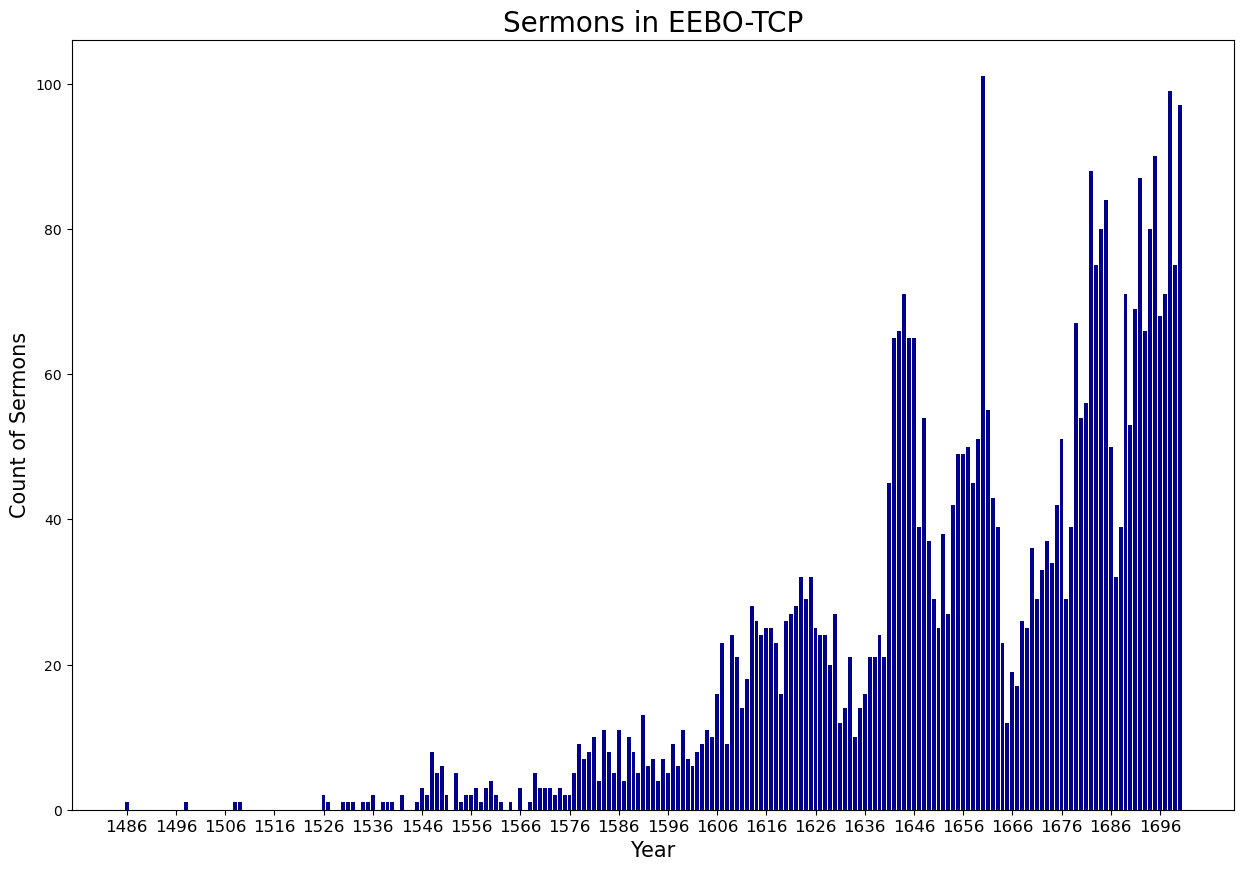

In [72]:
x,y = [],[]
date_counts = Counter(dates)
for date in sorted(date_counts): 
    if "?" in date: continue
    if "-" in date: 
        date = date.split("-")[0]
    if int(date) > 1700: continue
    x.append(int(date))
    y.append(date_counts[date])
visualize(x,y,'Sermons in EEBO-TCP','Year','Count of Sermons','darkblue')

In [69]:
print(Counter(dates).most_common(n=25))

[('1660', 101), ('1698', 99), ('1700', 97), ('1695', 90), ('1682', 88), ('1692', 87), ('1685', 84), ('1694', 80), ('1684', 80), ('1699', 75), ('1683', 75), ('1644', 71), ('1697', 71), ('1689', 71), ('1691', 69), ('1696', 68), ('1679', 67), ('1643', 66), ('1693', 66), ('1645', 65), ('1646', 65), ('1642', 65), ('1681', 56), ('1661', 55), ('1648', 54)]


In [70]:
posthumous = defaultdict(list)
within = defaultdict(list)
post_aut = []
within_aut = []
for idx, tcpID in enumerate(sermons): 
    date = dates[idx]
    aut = authors[idx].split("; ")
    if "?" in date: continue
    for author in aut:
        author = author.strip(".") 
        if "England and Wales" in author or "House" in author: 
            within[date].append(tcpID)
            break
        elif author == "Anonymous": 
            break
        elif re.search(r"d. \d+",author): 
            yod = re.findall(r"d. (\d+)",author)[0]
            if date <= yod:
                within[date].append(tcpID)
                within_aut.append(tcpID)
        elif re.search(r'\d+[?]{0,1}-\d+[?]{0,1}',author): 
            years = re.findall('\d+',author)
            if date <= years[-1]: 
                within[date].append(tcpID)
                within_aut.append(author)
            else: 
                posthumous[date].append(tcpID)
                post_aut.append(author)

In [71]:
print(Counter(post_aut).most_common(n=25))

[('Preston, John, 1587-1628', 18), ('Burroughs, Jeremiah, 1599-1646', 16), ('Love, Christopher, 1618-1651', 12), ('Tillotson, John, 1630-1694', 12), ('Calvin, Jean, 1509-1564', 12), ('Fenner, William, 1600-1640', 10), ('Smith, Henry, 1550?-1591', 7), ('Gray, Andrew, 1633-1656', 7), ('Manton, Thomas, 1620-1677', 7), ('Hopkins, Ezekiel, 1634-1690', 6), ('Andrewes, Lancelot, 1555-1626', 6), ('Donne, John, 1572-1631', 5), ('Boyle, Robert, 1627-1691', 5), ('Durham, James, 1622-1658', 5), ('Barrow, Isaac, 1630-1677', 5), ('Binning, Hugh, 1627-1653', 4), ('Ussher, James, 1581-1656', 4), ('Jewel, John, 1522-1571', 4), ('Rainolds, John, 1549-1607', 3), ('Shute, Josias, 1588-1643', 3), ('Nalton, James, 1600-1662', 3), ('Clagett, William, 1646-1688', 3), ('Bullinger, Heinrich, 1504-1575', 3), ('Bradford, John, 1510?-1555', 3), ('Luther, Martin, 1483-1546', 3)]


In [49]:
print(Counter(within_aut).most_common(n=25))

[('Burnet, Gilbert, 1643-1715', 28), ('Tillotson, John, 1630-1694', 24), ('Patrick, Simon, 1626-1707', 22), ('Sherlock, William, 1641?-1707', 21), ('Marshall, Stephen, 1594?-1655', 16), ('Goodwin, Thomas, 1600-1680', 16), ('Harris, Robert, 1581-1658', 15), ('Mather, Increase, 1639-1723', 15), ('Bridge, William, 1600?-1670', 14), ('Williams, John, 1636?-1709', 14), ('Fuller, Thomas, 1608-1661', 13), ('Sharp, John, 1645-1714', 13), ('Lloyd, William, 1627-1717', 13), ('Willard, Samuel, 1640-1707', 12), ('Taylor, Jeremy, 1613-1667', 12), ('Mather, Cotton, 1663-1728', 12), ('Bradford, Samuel, 1652-1731', 12), ('Hardy, Nathaniel, 1618-1670', 11), ('Fleetwood, William, 1656-1723', 11), ('Andrewes, Lancelot, 1555-1626', 11), ('Hall, Joseph, 1574-1656', 11), ('Hieron, Samuel, 1576?-1617', 11), ('Lambe, John, 1648 or 9-1708', 11), ('Keach, Benjamin, 1640-1704', 11), ('Ellis, Philip, 1652-1726', 10)]


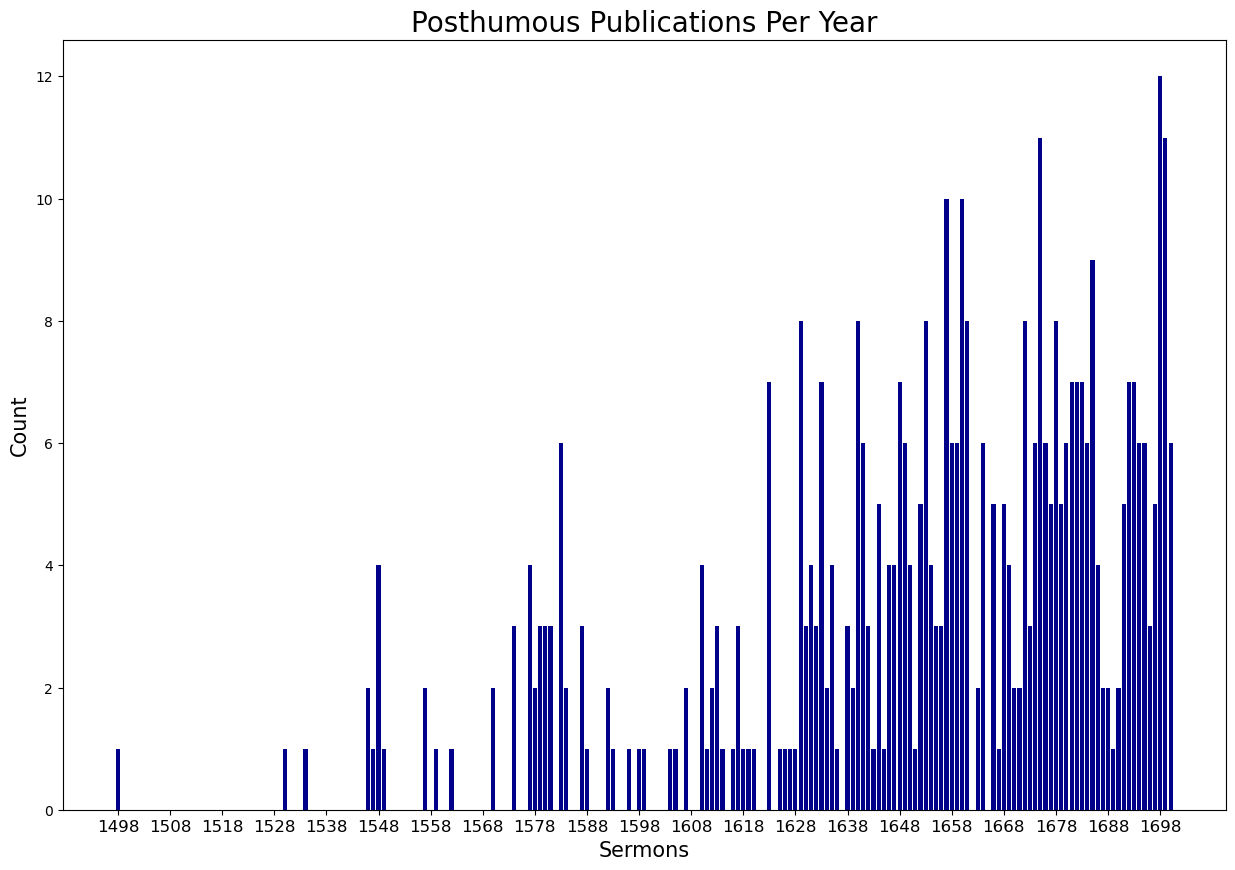

In [31]:
x,y = [],[]
date_counts = {date: len(tcpIDs) for date, tcpIDs in Counter(posthumous).items()}
for date in sorted(date_counts): 
    if "?" in date: continue
    if "-" in date: 
        date = date.split("-")[0]
    if int(date) > 1700: continue
    x.append(int(date))
    y.append(date_counts[date])
visualize(x,y,'Posthumous Publications Per Year','Sermons','Count','darkblue')

In [32]:
print(sorted(date_counts.items(),reverse=True, key=lambda x:x[1]))

[('1698', 12), ('1699', 11), ('1675', 11), ('1660', 10), ('1657', 10), ('1685', 9), ('1653', 8), ('1640', 8), ('1678', 8), ('1672', 8), ('1661', 8), ('1629', 8), ('1693', 7), ('1648', 7), ('1682', 7), ('1683', 7), ('1681', 7), ('1692', 7), ('1623', 7), ('1633', 7), ('1649', 6), ('1676', 6), ('1680', 6), ('1694', 6), ('1674', 6), ('1583', 6), ('1659', 6), ('1658', 6), ('1700', 6), ('1641', 6), ('1684', 6), ('1664', 6), ('1695', 6), ('1691', 5), ('1666', 5), ('1668', 5), ('1652', 5), ('1644', 5), ('1697', 5), ('1677', 5), ('1679', 5), ('1654', 4), ('1610', 4), ('1686', 4), ('1647', 4), ('1646', 4), ('1635', 4), ('1631', 4), ('1577', 4), ('1650', 4), ('1548', 4), ('1669', 4), ('1673', 3), ('1656', 3), ('1655', 3), ('1696', 3), ('1579', 3), ('1581', 3), ('1580', 3), ('1638', 3), ('1617', 3), ('1642', 3), ('1574', 3), ('1587', 3), ('1630', 3), ('1613', 3), ('1632', 3), ('1670', 2), ('1634', 2), ('1663', 2), ('1592', 2), ('1607', 2), ('1612', 2), ('1578', 2), ('1671', 2), ('1557', 2), ('1688

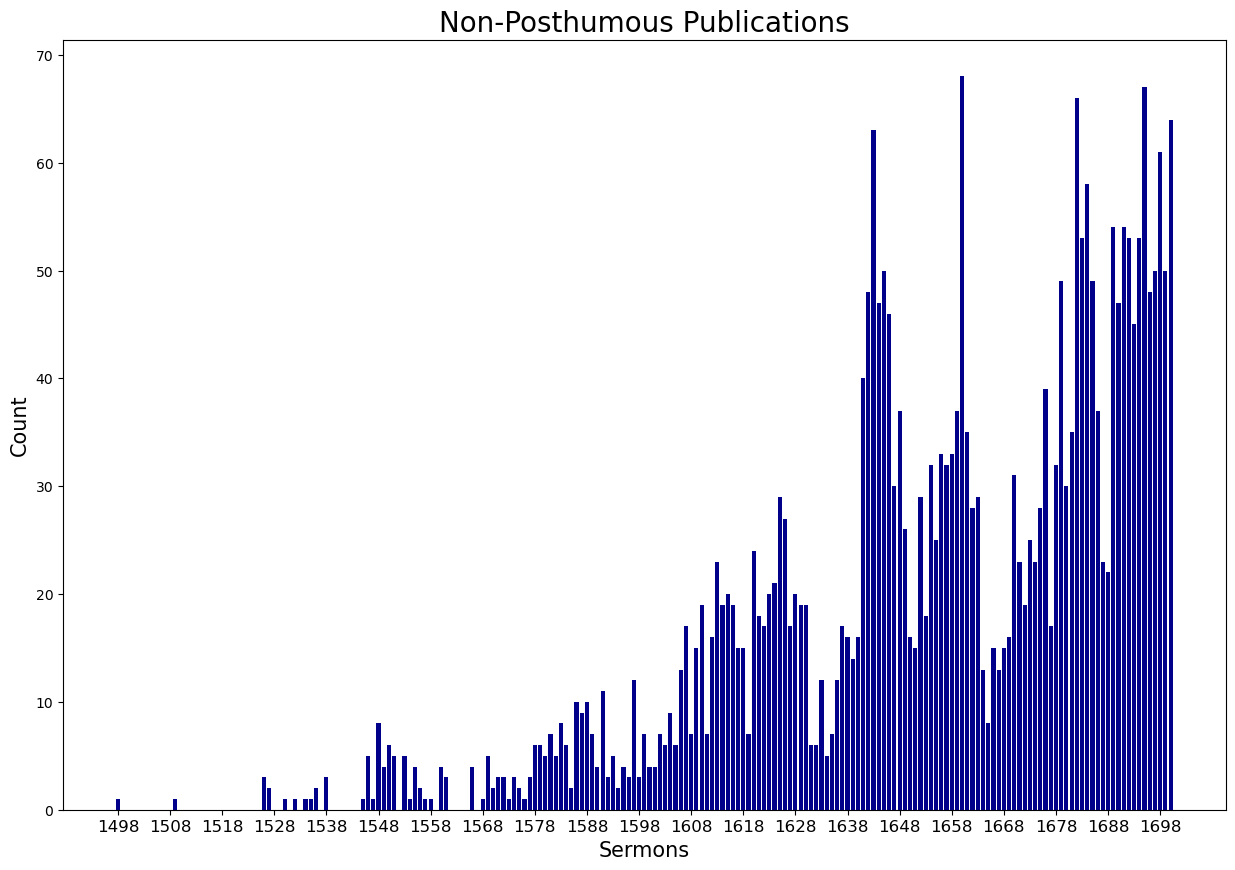

In [33]:
x,y = [],[]
date_counts = {date: len(tcpIDs) for date, tcpIDs in Counter(within).items()}
for date in sorted(date_counts): 
    if "?" in date: continue
    if "-" in date: 
        date = date.split("-")[0]
    if int(date) > 1700: continue
    x.append(int(date))
    y.append(date_counts[date])
visualize(x,y,'Non-Posthumous Publications','Sermons','Count','darkblue')

In [34]:
print(sorted(date_counts.items(),reverse=True, key=lambda x:x[1]))

[('1660', 68), ('1695', 67), ('1682', 66), ('1700', 64), ('1643', 63), ('1698', 61), ('1684', 58), ('1691', 54), ('1689', 54), ('1694', 53), ('1692', 53), ('1683', 53), ('1645', 50), ('1697', 50), ('1699', 50), ('1679', 49), ('1685', 49), ('1642', 48), ('1696', 48), ('1690', 47), ('1644', 47), ('1646', 46), ('1693', 45), ('1641', 40), ('1676', 39), ('1659', 37), ('1648', 37), ('1686', 37), ('1661', 35), ('1681', 35), ('1656', 33), ('1658', 33), ('1657', 32), ('1678', 32), ('1654', 32), ('1670', 31), ('1647', 30), ('1680', 30), ('1652', 29), ('1625', 29), ('1663', 29), ('1675', 28), ('1662', 28), ('1626', 27), ('1649', 26), ('1655', 25), ('1673', 25), ('1620', 24), ('1674', 23), ('1613', 23), ('1687', 23), ('1671', 23), ('1688', 22), ('1624', 21), ('1628', 20), ('1615', 20), ('1623', 20), ('1610', 19), ('1616', 19), ('1672', 19), ('1629', 19), ('1630', 19), ('1614', 19), ('1653', 18), ('1621', 18), ('1627', 17), ('1607', 17), ('1637', 17), ('1622', 17), ('1677', 17), ('1650', 16), ('163

In [65]:
sorted_dates = sorted(date_counts)
print(sorted_dates[0],sorted_dates[-1])
date_to_tcpID = {}
for idx, date in enumerate(dates):
    if date not in date_to_tcpID: 
        date_to_tcpID[date] = []
    date_to_tcpID[date].append(sermons[idx])

    

1498 1700


In [61]:
x,y = [],[]
author_pubs = defaultdict(list)
for idx, author in enumerate(authors): 
    aut = author.split("; ")
    for a in aut: 
        a = a.strip(r"\s+").strip(".")
        if re.search(r'\w+[\)]{0,},',a):
            additional = re.findall(r'\d+(\.[\w+\-\,\s+\.]+)',a)
            if len(additional) > 0: 
                a = re.sub(additional[0], "",a)
        author_pubs[a].append(dates[idx])

In [62]:
prefixes = {}
for a in author_pubs: 
    prefix = a.split(" ")[:2]
    prefix = " ".join(prefix)
    if prefix not in prefixes: 
        prefixes[prefix] = []
    if a not in prefixes[prefix]: 
        prefixes[prefix].append(a)

for prefix, p_list in prefixes.items(): 
    if len(p_list) > 1: 
        print(f"'{prefix}': {p_list},")

'Lover of': ['Lover of ale', 'Lover of peace and truth'],
'Owen, John,': ['Owen, John, 1616-1683', 'Owen, John, 1616-1683, attributed name', 'Owen, John, chaplain to Lord Grey of Ruthin'],
'Taylor, Thomas,': ['Taylor, Thomas, 1618-1682', 'Taylor, Thomas, 1576-1632'],
'Williams, John,': ['Williams, John, minister', 'Williams, John, Master of Arts', 'Williams, John, 1636?-1709', 'Williams, John, 1582-1650'],
'Sharp, John,': ['Sharp, John, of Froome, Somersetshire', 'Sharp, John, 1645-1714'],
'England and': ['England and Wales. Parliament. House of Commons', 'England and Wales. Parliament. aut', 'England and Wales. Parliament. House of Lords', 'England and Wales. Parliament', 'England and Wales. Parliament. House of Commons. Proceedings. 1642-08-31', 'England and Wales. Parliament. House of Commons. aut', 'England and Wales. Army. Honourable Artillery Company of London', 'England and Wales. Sovereign (1660-1685 : Charles II)'],
'Watson, Thomas,': ['Watson, Thomas, d. 1686', 'Watson, Thoma

In [37]:
author_counts = {aut: len(pubs) for aut, pubs in author_pubs.items()}
for aut,freq in sorted(author_counts.items(), key = lambda x: x[1],reverse=True): 
    print(freq, "\t", aut, "\t", Counter(author_pubs[aut]))

44 	 Anonymous 	 Counter({'1663': 4, '1660': 2, '1672': 2, '1585': 2, '1641': 2, '1643': 2, '1698': 2, '1688': 2, '1683': 2, '1673': 1, '1611': 1, '1675': 1, '1687': 1, '1662': 1, '1678': 1, '1645': 1, '1689': 1, '1542': 1, '1559': 1, '1704': 1, '1670': 1, '1699': 1, '1644': 1, '1671': 1, '1674': 1, '1680': 1, '1607': 1, '1635': 1, '1548': 1, '1667': 1, '1694': 1, '1684': 1, '1650': 1})
36 	 Tillotson, John, 1630-1694. 	 Counter({'1700': 4, '1694': 4, '1679': 3, '1695': 3, '1678': 2, '1698': 2, '1692': 2, '1682': 2, '1676': 1, '1691': 1, '1687': 1, '1675': 1, '1664': 1, '1696': 1, '1680': 1, '1693': 1, '1689': 1, '1697': 1, '1685': 1, '1681': 1, '1699': 1, '1686': 1})
30 	 Burnet, Gilbert, 1643-1715. 	 Counter({'1689': 7, '1691': 3, '1690': 3, '1675': 3, '1684': 2, '1681': 2, '1697': 2, '1694': 2, '1700': 1, '1680': 1, '1695': 1, '1698': 1, '1692': 1, '1678': 1})
25 	 Stillingfleet, Edward, 1635-1699. 	 Counter({'1700': 2, '1669': 2, '1681': 2, '1697': 2, '1694': 2, '1693': 1, '1692': 